In [124]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# load data

In [125]:
data = pd.read_csv('../data/proceed/non_encode_data.csv')
data.head()

C:\Users\exp55\AppData\Local\Temp\ipykernel_6888\149924035.py:1: DtypeWarning: Columns (2,4,8,20,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/proceed/non_encode_data.csv')


,accounting_date,company_code,customer_code,customer_district_code,item_code,business_area_code,item_group_code,item_class_code,item_type,bonus_group_code,...,line_number,invoice_date,customer_order_number,order_date,dss_update_time,day_gap,order_group,value_sales_log_plus1_transformed,value_cost_log_plus1_transformed,value_quantity_log_plus1_transformed
0,2012-05-09,101,411800601,410,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-05-09,2865354,2012-05-09,49:58.7,0,Normal Order,5.390897,5.188489,4.442651
1,2012-02-16,101,361000403,300,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-02-16,2833515,2012-02-16,49:58.7,0,Normal Order,3.670715,3.275513,2.564949
2,2012-05-09,101,361000403,300,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-05-09,2864857,2012-05-08,49:58.7,1,Normal Order,3.718438,3.275513,2.564949
3,2012-05-18,101,565540415,500,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-05-18,2869759,2012-05-18,49:58.7,0,Other,3.049273,2.619467,1.945910
4,2012-01-09,101,565540415,500,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-01-09,2819189,2012-01-09,49:58.7,0,Other,3.002708,2.619467,1.945910


# fix data type

In [126]:
data['order_date'] = pd.to_datetime(data['order_date']) #convert to datetime
data['customer_order_number'] = data['customer_order_number'].astype(str) #convert to string
data['customer_code'] = data['customer_code'].astype(str) #convert to string


# Create RFM metric

RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to segment customers based on their purchasing behaviors. It helps businesses identify their most valuable customers and tailor their marketing strategies accordingly. Here’s a breakdown of each component:

**Recency** (R): Measures how recently a customer made a purchase. Customers who purchased more recently are generally more likely to return, as recent activity often indicates stronger engagement.

**Frequency** (F): Measures how often a customer makes a purchase. High-frequency customers are typically more loyal and engaged. Frequency helps businesses understand customer loyalty and predict the likelihood of repeat purchases.

**Monetary** (M): Measures the amount of money a customer spends. Customers with higher monetary values contribute more to the company’s revenue, making them more valuable.

Each component is scored, often on a scale (e.g., 1-5), and combined to create an RFM score for each customer. For instance:

High R, High F, High M: These customers are the most valuable—they shop often, have shopped recently, and spend a lot. They're prime targets for loyalty programs or exclusive offers.
High R, Low F, Low M: These customers recently made a small or infrequent purchase. They might be encouraged to make a second purchase with tailored promotions.
Low R, High F, High M: These customers are big spenders but haven't purchased recently, so a win-back campaign could be effective.

In [127]:
data = data[data['value_sales'] > 0] #remove negative sales

remove nagative sales because we want to focus on gross sales rather than net sales

In [128]:
# Reference date for calculating recency
reference_date = pd.to_datetime('2013-12-31')

# Group by customer_code to calculate RFM metrics
rfm = data.groupby('customer_code').agg({
    'order_date': lambda x: (reference_date - x.max()).days,  # Recency
    'customer_order_number': 'nunique',  # Frequency
    'value_sales': 'sum'  # Monetary
})

# Rename columns for clarity
rfm.columns = ['recency', 'frequency', 'monetary']

# Display the RFM table
rfm = rfm.reset_index()
rfm.round(2)


,customer_code,recency,frequency,monetary
0,100050100,12,30,4835922.58
1,100210100,40,22,73415.70
2,100230100,266,4,37190.92
3,100250200,40,4,13273.45
4,100270100,42,22,91784.41
...,...,...,...,...
4416,ZI9000101,22,157,307456.52
4417,ZI9000102,28,237,1172088.92
4418,ZI9000103,340,1,658.66
4419,ZI9500101,382,1,212.11


recency metric was calculated by refference date - max(order_date)
refference date is the date that we are interest such as the end of years or the end of month, or the end of quarter

frequency metric was calculated by count unique customer_order_number

Monetary metric was calculated by sum value_sales

In [129]:
# Assign scores using quantiles
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine the scores to create a composite RFM score
rfm['RFM_score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

# Display the scored RFM table
rfm[['customer_code', 'recency', 'frequency', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_score']]


,customer_code,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,100050100,12,30,4.835923e+06,5,3,5,535
1,100210100,40,22,7.341570e+04,3,3,4,334
2,100230100,266,4,3.719092e+04,1,1,3,113
3,100250200,40,4,1.327345e+04,3,1,3,313
4,100270100,42,22,9.178441e+04,3,3,4,334
...,...,...,...,...,...,...,...,...
4416,ZI9000101,22,157,3.074565e+05,3,4,5,345
4417,ZI9000102,28,237,1.172089e+06,3,5,5,355
4418,ZI9000103,340,1,6.586650e+02,1,1,1,111
4419,ZI9500101,382,1,2.121120e+02,1,1,1,111


In [130]:
def segment_customer(rfm_score):
    if rfm_score == '555':
        return 'Champion'
    elif rfm_score.startswith('5'):
        return 'Loyal Customer'
    elif rfm_score[1] == '5':
        return 'Frequent Buyer'
    elif rfm_score[0] == '1':
        return 'At Risk'
    else:
        return 'Others'

# Apply segmentation
rfm['segment'] = rfm['RFM_score'].apply(segment_customer)

# Display the segmented RFM table
rfm[['customer_code', 'recency', 'frequency', 'monetary', 'RFM_score', 'segment']]


,customer_code,recency,frequency,monetary,RFM_score,segment
0,100050100,12,30,4.835923e+06,535,Loyal Customer
1,100210100,40,22,7.341570e+04,334,Others
2,100230100,266,4,3.719092e+04,113,At Risk
3,100250200,40,4,1.327345e+04,313,Others
4,100270100,42,22,9.178441e+04,334,Others
...,...,...,...,...,...,...
4416,ZI9000101,22,157,3.074565e+05,345,Others
4417,ZI9000102,28,237,1.172089e+06,355,Frequent Buyer
4418,ZI9000103,340,1,6.586650e+02,111,At Risk
4419,ZI9500101,382,1,2.121120e+02,111,At Risk


# Quartile RFM

In [131]:
data['quarter'] = data['order_date'].dt.to_period("Q")
data['quarter']

0          2012Q2
1          2012Q1
2          2012Q2
3          2012Q2
4          2012Q1
            ...  
1971495    2013Q4
1971496    2013Q2
1971497    2013Q4
1971498    2013Q4
1971499    2013Q3
Name: quarter, Length: 1849971, dtype: period[Q-DEC]

In [132]:
# Reference date (for each quarter, you may update accordingly for your needs)
data['quarter_end_date'] = data['quarter'].dt.end_time
data['quarter_end_date'] = pd.to_datetime(data['quarter_end_date'].dt.date)
#data['quarter'] = data['quarter'].astype(str)
data['order_date'] = pd.to_datetime(data['order_date'])
data['quarter_end_date'] = pd.to_datetime(data['quarter_end_date'])
# Group by customer and quarter to calculate RFM metrics
quarterly_rfm = data.groupby(['customer_code', 'quarter', 'quarter_end_date']).agg({
    'order_date': lambda x: (data.loc[x.index, 'quarter_end_date'].iloc[0] - x.max()).days,  # Recency
    'customer_order_number': 'nunique',  # Frequency
    'value_sales': 'sum'  # Monetary
})

# Rename columns
quarterly_rfm.columns = ['recency', 'frequency', 'monetary']

# Display the quarterly RFM table
quarterly_rfm = quarterly_rfm.reset_index()
quarterly_rfm.round(2)


,customer_code,quarter,quarter_end_date,recency,frequency,monetary
0,100050100,2013Q2,2013-06-30,3,12,3947816.08
1,100050100,2013Q3,2013-09-30,8,8,606204.00
2,100050100,2013Q4,2013-12-31,12,10,281902.50
3,100210100,2012Q1,2012-03-31,18,3,5555.12
4,100210100,2012Q2,2012-06-30,25,4,7347.79
...,...,...,...,...,...,...
26073,ZI9000102,2013Q3,2013-09-30,0,28,188963.78
26074,ZI9000102,2013Q4,2013-12-31,28,22,30793.17
26075,ZI9000103,2013Q1,2013-03-31,65,1,658.66
26076,ZI9500101,2012Q4,2012-12-31,17,1,212.11


In [133]:
# Assign scores using quantiles
quarterly_rfm['recency_score'] = pd.qcut(quarterly_rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
quarterly_rfm['frequency_score'] = pd.qcut(quarterly_rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
quarterly_rfm['monetary_score'] = pd.qcut(quarterly_rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine the scores to create a composite RFM score
quarterly_rfm['RFM_score'] = quarterly_rfm['recency_score'].astype(str) + quarterly_rfm['frequency_score'].astype(str) + quarterly_rfm['monetary_score'].astype(str)

# Display the scored RFM table
quarterly_rfm[['customer_code', 'quarter', 'recency', 'frequency', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_score']]


,customer_code,quarter,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,100050100,2013Q2,3,12,3.947816e+06,5,3,5,535
1,100050100,2013Q3,8,8,6.062040e+05,4,3,5,435
2,100050100,2013Q4,12,10,2.819025e+05,3,3,5,335
3,100210100,2012Q1,18,3,5.555120e+03,2,2,3,223
4,100210100,2012Q2,25,4,7.347790e+03,2,2,3,223
...,...,...,...,...,...,...,...,...,...
26073,ZI9000102,2013Q3,0,28,1.889638e+05,5,4,5,545
26074,ZI9000102,2013Q4,28,22,3.079317e+04,1,4,5,145
26075,ZI9000103,2013Q1,65,1,6.586650e+02,1,1,1,111
26076,ZI9500101,2012Q4,17,1,2.121120e+02,2,1,1,211


In [134]:
quarterly_rfm = quarterly_rfm[quarterly_rfm['quarter_end_date'] >= '2012-01-01']

In [135]:
# Apply segmentation
quarterly_rfm['segment'] = quarterly_rfm['RFM_score'].apply(segment_customer)

C:\Users\exp55\AppData\Local\Temp\ipykernel_6888\1185202073.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=quarterly_rfm, x='quarter_end_date', y='monetary_score', estimator='mean', ci=None, label='Monetary Value')
C:\Users\exp55\AppData\Local\Temp\ipykernel_6888\1185202073.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=quarterly_rfm, x='quarter_end_date', y='recency_score', estimator='mean', ci=None, label='Recency')
C:\Users\exp55\AppData\Local\Temp\ipykernel_6888\1185202073.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=quarterly_rfm, x='quarter_end_date', y='frequency_score', estimator='mean', ci=None, label='Frequency')


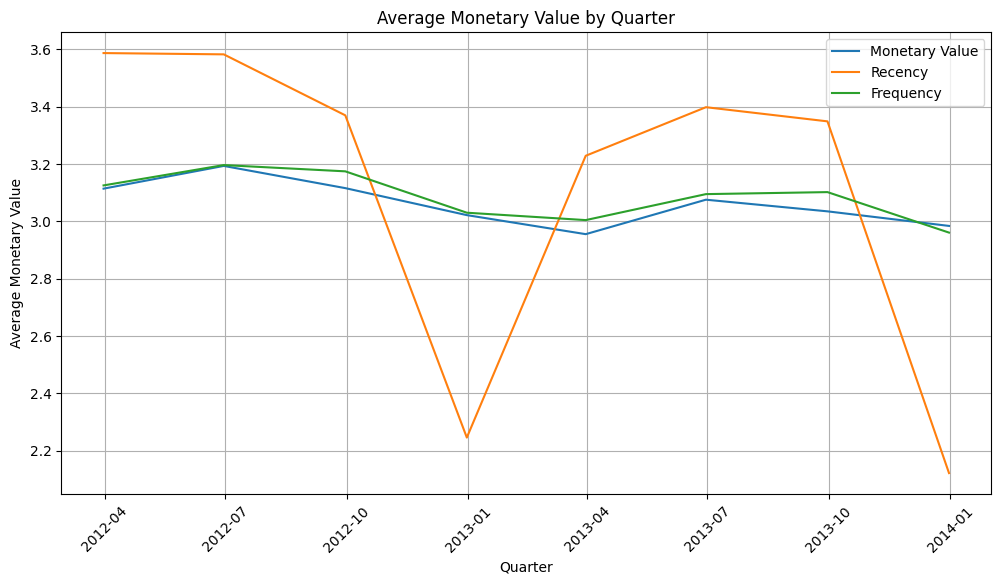

In [136]:
#plot line chart for average monetary value
plt.figure(figsize=(12, 6))
sns.lineplot(data=quarterly_rfm, x='quarter_end_date', y='monetary_score', estimator='mean', ci=None, label='Monetary Value')
sns.lineplot(data=quarterly_rfm, x='quarter_end_date', y='recency_score', estimator='mean', ci=None, label='Recency')
sns.lineplot(data=quarterly_rfm, x='quarter_end_date', y='frequency_score', estimator='mean', ci=None, label='Frequency')
plt.title('Average Monetary Value by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis() 
plt.show()

As you can see in line chart, it custome tend to buy product in Q2, but low recency at the end of year

In [137]:
#count the number of customers in each segment quarterly
segment_counts = quarterly_rfm.groupby(['quarter', 'segment']).size().unstack().fillna(0)
segment_counts = segment_counts.div(segment_counts.sum(axis=1), axis=0).round(2)
segment_counts

segment,At Risk,Champion,Frequent Buyer,Loyal Customer,Others
quarter,,,,,
2012Q1,0.16,0.14,0.02,0.29,0.39
2012Q2,0.16,0.17,0.02,0.27,0.38
2012Q3,0.19,0.14,0.05,0.19,0.43
2012Q4,0.24,0.00,0.19,0.00,0.56
2013Q1,0.18,0.09,0.07,0.12,0.54
2013Q2,0.17,0.14,0.05,0.17,0.47
2013Q3,0.18,0.11,0.07,0.18,0.46
2013Q4,0.26,0.00,0.17,0.00,0.56


<Figure size 1200x600 with 0 Axes>

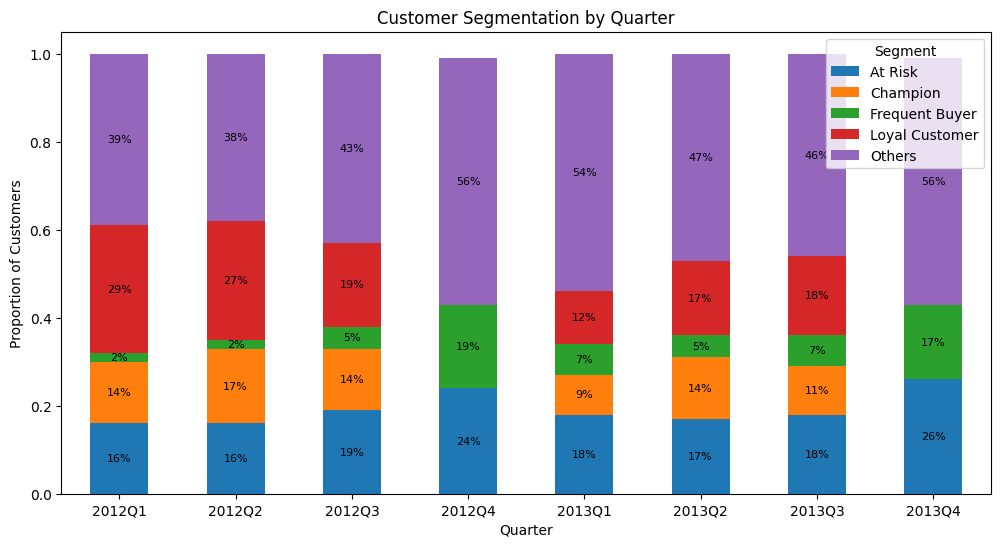

In [138]:
#plot the stacked bar chart
plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Customer Segmentation by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.legend(title='Segment')
#show values on each bar
# Displaying values on each segment of the bar
for c in plt.gca().containers:
    # Add labels to each segment in the stack
    labels = [f"{v.get_height() * 100:.0f}%" if v.get_height() > 0.01 else '' for v in c]  # Only show if > 5%
    plt.gca().bar_label(c, labels=labels, label_type='center', fontsize=8)
plt.show()

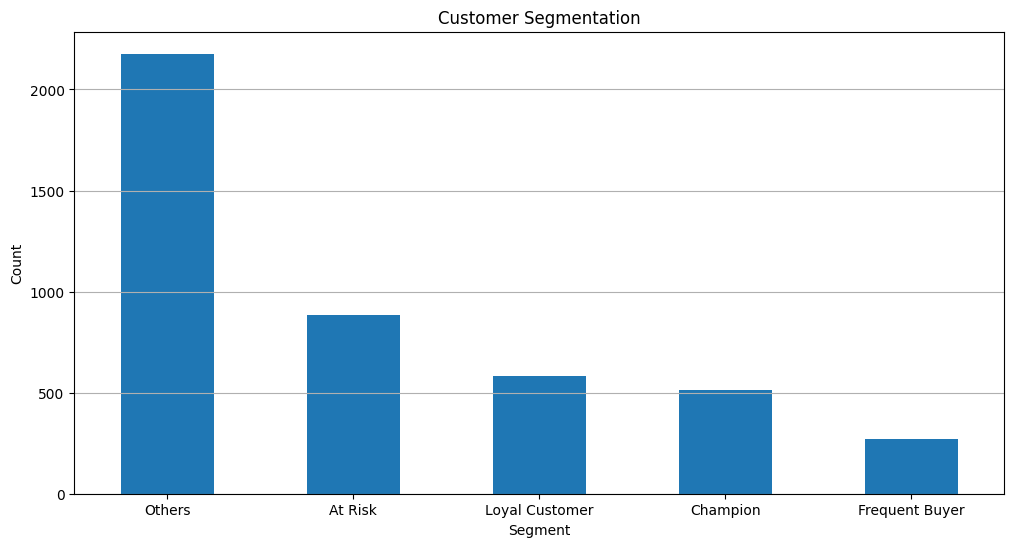

In [139]:
rfm['segment'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Customer Segmentation')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')